In [2]:
import tensorflow as tf
import keras
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Flatten, Dense, Dropout, Activation, Permute, Bidirectional, GRU
from keras.layers import Input, Reshape
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
X_test = np.load('/content/drive/My Drive/EEG_project/data/X_test.npy')
y_test = np.load('/content/drive/My Drive/EEG_project/data/y_test.npy')
person_train_valid = np.load('/content/drive/My Drive/EEG_project/data/person_train_valid.npy')
X_train_valid = np.load('/content/drive/My Drive/EEG_project/data/X_train_valid.npy')
y_train_valid = np.load('/content/drive/My Drive/EEG_project/data/y_train_valid.npy')
person_test = np.load('/content/drive/My Drive/EEG_project/data/person_test.npy')

In [5]:
print('Taining/Valid data shape: {}'.format(X_train_valid.shape))
print('Test data shape: {}'.format(X_test.shape))
print('Training/Valid target shape: {}'.format(y_train_valid.shape))
print('Test target shape: {}'.format(y_test.shape))
print('Person train/valid shape: {}'.format(person_train_valid.shape))
print('Person test shape: {}'.format(person_test.shape))


Taining/Valid data shape: (2115, 25, 1000)
Test data shape: (443, 25, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [6]:
X_train = np.zeros((2115, 22, 1000))
X_train = X_train_valid[:,:22,:]
X_train = np.expand_dims(X_train, 3)
print('Taining/Valid data shape: {}'.format(X_train.shape))
xtest = np.zeros((443, 22, 1000))
xtest = X_test[:,:22,:]
xtest = np.expand_dims(xtest, 3)
print('Test data shape: {}'.format(xtest.shape))
y_train = np.zeros((2115, 4))
y_train[y_train_valid==769, 0] = 1
y_train[y_train_valid==770, 1] = 1
y_train[y_train_valid==771, 2] = 1
y_train[y_train_valid==772, 3] = 1

Taining/Valid data shape: (2115, 22, 1000, 1)
Test data shape: (443, 22, 1000, 1)


In [0]:
random0 = np.zeros(len(y_train[y_train_valid==769]))
random0[:500] = 1
np.random.shuffle(random0)

random1 = np.zeros(len(y_train[y_train_valid==770]))
random1[:500] = 1
np.random.shuffle(random1)

random2 = np.zeros(len(y_train[y_train_valid==771]))
random2[:500] = 1
np.random.shuffle(random2)

random3 = np.zeros(len(y_train[y_train_valid==772]))
random3[:500] = 1
np.random.shuffle(random3)

X_train_ub = np.zeros((2000, 22, 1000, 1))
y_train_ub = np.zeros((2000, 4))
X_train_ub[:500] = X_train[y_train_valid==769][random0==1]
y_train_ub[:500] = y_train[y_train_valid==769][random0==1]

X_train_ub[500:1000] = X_train[y_train_valid==770][random1==1]
y_train_ub[500:1000] = y_train[y_train_valid==770][random1==1]

X_train_ub[1000:1500] = X_train[y_train_valid==771][random2==1]
y_train_ub[1000:1500] = y_train[y_train_valid==771][random2==1]

X_train_ub[1500:2000] = X_train[y_train_valid==772][random3==1]
y_train_ub[1500:2000] = y_train[y_train_valid==772][random3==1]

random_idx = np.arange(2000)
np.random.shuffle(random_idx)
X_train_ub = X_train_ub[random_idx]
y_train_ub = y_train_ub[random_idx]

In [0]:
def crnn_model():
    activation = 'elu'
    init = 'glorot_uniform'
    model = Sequential()

    #Block 1
    model.add(Conv2D(filters = 25, kernel_size = (10,1), kernel_initializer=init, input_shape=X_train[0].shape))
    model.add(Conv2D(filters = 32, kernel_size = (1, 77), kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(3, 1), strides=3))
    model.add(Dropout(0.5))

    #Block 2
    model.add(Conv2D(filters = 64, kernel_size = (1, 10), kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(1, 3), strides=3))
    model.add(Dropout(0.5))

    #Block 3
    model.add(Conv2D(filters = 100, kernel_size = (1, 10), kernel_initializer = init))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(1, 3), strides=3))
    model.add(Dropout(0.5))

    #Block 4
    model.add(Conv2D(filters = 200, kernel_size = (1, 3), kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(1, 3), strides=3))
    model.add(Dropout(0.5))
    
    #RNN Block
    model.add(Reshape((-1, 200)))
    model.add(GRU(200,return_sequences=True,dropout=0.1))
#     model.add(GRU(200,return_sequences=True,dropout=0.1))
#     model.add(GRU(200,return_sequences=True,dropout=0.1))
    model.add(GRU(200,dropout=0.1))
    
    #model.add(Flatten())
    model.add(Dense(units=4, kernel_initializer=init, kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    
    return model
#   init = 'glorot_uniform'
#   model = Sequential()
  
#   # 1st Part
#   model.add(Conv2D(filters = 25, input_shape = (22, 1000, 1), kernel_size = (1, 10), kernel_initializer = init))
# #   model.add(BatchNormalization())
# #   model.add(Activation('relu'))
# #   model.add(MaxPooling2D(pool_size = (3, 1)))
  
#   # 2nd Part
#   model.add(Conv2D(filters = 50, kernel_size = (1, 10), kernel_initializer = init))
#   model.add(BatchNormalization())
#   model.add(Activation('relu'))
#   model.add(MaxPooling2D(pool_size = (1, 3),strides = 3))
#   model.add(Dropout(0.5))
  
#   # 3rd Part
#   model.add(Conv2D(filters = 128, kernel_size = (1, 10), kernel_initializer = init))
#   model.add(BatchNormalization())
#   model.add(Activation('relu'))
#   model.add(MaxPooling2D(pool_size = (1, 3), strides = 3))
#   model.add(Dropout(0.5))
  
#   # 4th Part
#   model.add(Conv2D(filters = 256, kernel_size = (1, 10), kernel_initializer = init))
#   model.add(BatchNormalization())
#   model.add(Activation('relu'))
#   model.add(MaxPooling2D(pool_size=(1, 3), strides=3))
#   model.add(Dropout(0.5))
  
#   # 5th Part
#   model.add(Reshape((-1, 256)))
#   model.add(GRU(256,return_sequences=True,dropout=0.1))
#   model.add(GRU(256,return_sequences=True,dropout=0.1))
#   model.add(GRU(256,return_sequences=True,dropout=0.1))
#   model.add(GRU(256,dropout=0.1))
  
  
  
# #   model.add(Flatten())
#   model.add(Dense(units=4, kernel_initializer=init))
#   model.add(Activation('softmax'))
#   model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.adam(lr = 0.001), metrics = ['accuracy'])  
#   return model

In [28]:
i = 1
model = crnn_model()
for layers in model.layers:
    print('Layer %d:' % i, layers.name)
#     print(layers.__dict__)
    if(hasattr(layers,'kernel_initializer')):
        print(layers.kernel_initializer)
    print(layers.input_shape)
    print(layers.output_shape)
    print()
    i += 1

Layer 1: conv2d_41
(None, 22, 1000, 1)
(None, 13, 1000, 25)

Layer 2: conv2d_42
(None, 13, 1000, 25)
(None, 13, 924, 32)

Layer 3: batch_normalization_41
(None, 13, 924, 32)
(None, 13, 924, 32)

Layer 4: activation_41
(None, 13, 924, 32)
(None, 13, 924, 32)

Layer 5: max_pooling2d_33
(None, 13, 924, 32)
(None, 4, 308, 32)

Layer 6: dropout_33
(None, 4, 308, 32)
(None, 4, 308, 32)

Layer 7: conv2d_43
(None, 4, 308, 32)
(None, 4, 299, 64)

Layer 8: batch_normalization_42
(None, 4, 299, 64)
(None, 4, 299, 64)

Layer 9: activation_42
(None, 4, 299, 64)
(None, 4, 299, 64)

Layer 10: max_pooling2d_34
(None, 4, 299, 64)
(None, 2, 99, 64)

Layer 11: dropout_34
(None, 2, 99, 64)
(None, 2, 99, 64)

Layer 12: conv2d_44
(None, 2, 99, 64)
(None, 2, 90, 100)

Layer 13: batch_normalization_43
(None, 2, 90, 100)
(None, 2, 90, 100)

Layer 14: activation_43
(None, 2, 90, 100)
(None, 2, 90, 100)

Layer 15: max_pooling2d_35
(None, 2, 90, 100)
(None, 1, 30, 100)

Layer 16: dropout_35
(None, 1, 30, 100)
(No

In [29]:
model = crnn_model()
model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.adam(lr = 0.001,decay=1e-5), metrics = ['accuracy'])  
result = model.fit(X_train, y_train, batch_size = 16, validation_split = 0.2, epochs = 150)

Train on 1692 samples, validate on 423 samples
Epoch 1/150
1692/1692 [==============================] - 16s 10ms/step - loss: 1.8331 - acc: 0.2636 - val_loss: 1.8515 - val_acc: 0.3144
Epoch 2/150
1692/1692 [==============================] - 10s 6ms/step - loss: 1.6242 - acc: 0.2878 - val_loss: 1.6918 - val_acc: 0.3333
Epoch 3/150
1692/1692 [==============================] - 10s 6ms/step - loss: 1.5326 - acc: 0.2985 - val_loss: 1.5263 - val_acc: 0.3144
Epoch 4/150
1692/1692 [==============================] - 10s 6ms/step - loss: 1.4849 - acc: 0.3162 - val_loss: 1.4966 - val_acc: 0.3050
Epoch 5/150
1692/1692 [==============================] - 10s 6ms/step - loss: 1.4477 - acc: 0.3227 - val_loss: 1.5636 - val_acc: 0.2979
Epoch 6/150
1692/1692 [==============================] - 10s 6ms/step - loss: 1.4251 - acc: 0.3481 - val_loss: 1.4368 - val_acc: 0.3664
Epoch 7/150
1692/1692 [==============================] - 10s 6ms/step - loss: 1.3774 - acc: 0.3729 - val_loss: 1.3824 - val_acc: 0.3901


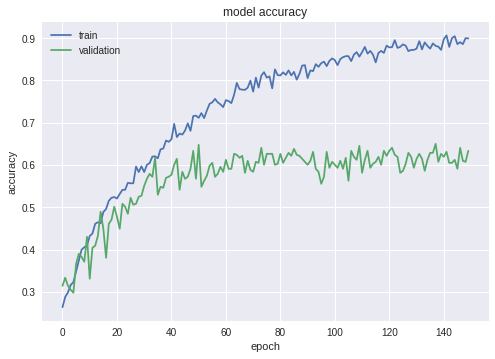

In [30]:
results = []
results.append(result.history['val_acc'])

plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [31]:
test_results = model.predict(x = xtest, batch_size = 16)
categ_results = np.argmax(test_results, axis = 1)
categ_test = np.argmax(y_test)
test_acc = np.sum(categ_results==(y_test-769)) / len(categ_results)
print('Training Accuracy: %.3f' % result.history['acc'][-1])
print('Validation Accuracy: %.3f' % max(result.history['val_acc']))
print('Testing Accuracy: %.3f' % test_acc)

Training Accuracy: 0.900
Validation Accuracy: 0.650
Testing Accuracy: 0.625
